In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random as rn
from datetime import datetime

from tensorflow.keras import backend as K

In [4]:
os.getcwd()

'/home/siva/Downloads/captcha-recognition-pytorch-master'

In [46]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# set the seed for random number generator
rn.seed(seed)

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
#tf.set_random_seed(seed)
tf.random.set_seed(seed)

# We will be using CuDNN implementation of RNNs which already is non-reproducible
# So I am trying to get results as close as possible on different runs
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)




In [47]:
# Path to the data directory
data_dir = Path("/home/siva/Desktop/sample_captcha/")

In [48]:
# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  100
Number of labels found:  100
Number of unique characters:  10
Characters present:  {'0', '9', '1', '5', '6', '3', '4', '8', '2', '7'}


In [49]:
characters

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [50]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None
)

In [51]:
#!pip install tensorflow==2.3.1

In [52]:
# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [53]:
def split_data(images, labels, train_size=0.85, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [54]:
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [55]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

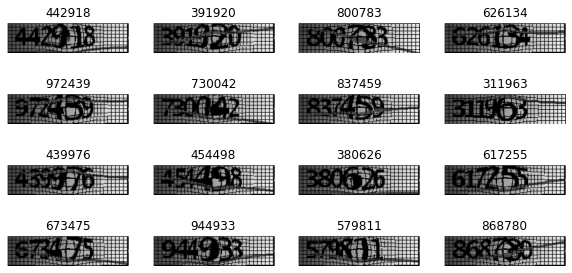

In [58]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [59]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [60]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [61]:
epochs = 1000
early_stopping_patience = 10000
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/1000
6/6 [==============================] - 3s 521ms/step - loss: 41.8808 - val_loss: 19.2091
Epoch 2/1000
6/6 [==============================] - 1s 192ms/step - loss: 18.2965 - val_loss: 16.5810
Epoch 3/1000
6/6 [==============================] - 1s 201ms/step - loss: 16.0084 - val_loss: 16.3223
Epoch 4/1000
6/6 [==============================] - 1s 211ms/step - loss: 15.9294 - val_loss: 15.7138
Epoch 5/1000
6/6 [==============================] - 1s 213ms/step - loss: 15.7199 - val_loss: 15.8503
Epoch 6/1000
6/6 [==============================] - 1s 208ms/step - loss: 15.6265 - val_loss: 15.6145
Epoch 7/1000
6/6 [==============================] - 1s 199ms/step - loss: 15.6068 - val_loss: 15.5850
Epoch 8/1000
6/6 [==============================] - 1s 202ms/step - loss: 15.5414 - val_loss: 15.6088
Epoch 9/1000
6/6 [==============================] - 1s 173ms/step - loss: 15.5421 - val_loss: 15.5763
Epoch 10/1000
6/6 [==============================] - 1s 167ms/step - loss: 15.5199

Epoch 81/1000
6/6 [==============================] - 1s 170ms/step - loss: 6.6976 - val_loss: 7.4188
Epoch 82/1000
6/6 [==============================] - 1s 169ms/step - loss: 6.3524 - val_loss: 7.8240
Epoch 83/1000
6/6 [==============================] - 1s 173ms/step - loss: 6.0219 - val_loss: 6.7185
Epoch 84/1000
6/6 [==============================] - 1s 168ms/step - loss: 5.1763 - val_loss: 6.3143
Epoch 85/1000
6/6 [==============================] - 1s 169ms/step - loss: 4.9836 - val_loss: 6.1001
Epoch 86/1000
6/6 [==============================] - 1s 170ms/step - loss: 4.5014 - val_loss: 5.6671
Epoch 87/1000
6/6 [==============================] - 1s 174ms/step - loss: 4.2858 - val_loss: 5.3885
Epoch 88/1000
6/6 [==============================] - 1s 170ms/step - loss: 3.9941 - val_loss: 5.5195
Epoch 89/1000
6/6 [==============================] - 1s 167ms/step - loss: 3.7242 - val_loss: 5.3226
Epoch 90/1000
6/6 [==============================] - 1s 171ms/step - loss: 3.4992 - val_los

6/6 [==============================] - 1s 169ms/step - loss: 0.1531 - val_loss: 1.8894
Epoch 162/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.1425 - val_loss: 1.9647
Epoch 163/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.1537 - val_loss: 1.6363
Epoch 164/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.1603 - val_loss: 1.6185
Epoch 165/1000
6/6 [==============================] - 1s 180ms/step - loss: 0.1600 - val_loss: 1.7815
Epoch 166/1000
6/6 [==============================] - 1s 176ms/step - loss: 0.1408 - val_loss: 1.8036
Epoch 167/1000
6/6 [==============================] - 1s 170ms/step - loss: 0.2021 - val_loss: 1.6538
Epoch 168/1000
6/6 [==============================] - 1s 172ms/step - loss: 0.1385 - val_loss: 1.7226
Epoch 169/1000
6/6 [==============================] - 1s 167ms/step - loss: 0.1258 - val_loss: 1.7542
Epoch 170/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.1401 - val_loss: 1.

6/6 [==============================] - 1s 168ms/step - loss: 0.0807 - val_loss: 3.1632
Epoch 242/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.0833 - val_loss: 2.9354
Epoch 243/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0571 - val_loss: 3.0191
Epoch 244/1000
6/6 [==============================] - 1s 166ms/step - loss: 0.0779 - val_loss: 2.8266
Epoch 245/1000
6/6 [==============================] - 1s 167ms/step - loss: 0.0560 - val_loss: 2.7300
Epoch 246/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0940 - val_loss: 2.5554
Epoch 247/1000
6/6 [==============================] - 1s 174ms/step - loss: 0.0546 - val_loss: 2.4077
Epoch 248/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0586 - val_loss: 2.4952
Epoch 249/1000
6/6 [==============================] - 1s 171ms/step - loss: 0.0567 - val_loss: 2.6603
Epoch 250/1000
6/6 [==============================] - 1s 170ms/step - loss: 0.0495 - val_loss: 2.

6/6 [==============================] - 1s 153ms/step - loss: 0.0275 - val_loss: 2.4517
Epoch 322/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0274 - val_loss: 2.4941
Epoch 323/1000
6/6 [==============================] - 1s 151ms/step - loss: 0.0471 - val_loss: 2.5937
Epoch 324/1000
6/6 [==============================] - 1s 152ms/step - loss: 0.0251 - val_loss: 2.6724
Epoch 325/1000
6/6 [==============================] - 1s 154ms/step - loss: 0.0648 - val_loss: 2.7255
Epoch 326/1000
6/6 [==============================] - 1s 156ms/step - loss: 0.1009 - val_loss: 2.9478
Epoch 327/1000
6/6 [==============================] - 1s 155ms/step - loss: 0.0528 - val_loss: 3.3164
Epoch 328/1000
6/6 [==============================] - 1s 155ms/step - loss: 0.0551 - val_loss: 2.9174
Epoch 329/1000
6/6 [==============================] - 1s 154ms/step - loss: 0.0426 - val_loss: 2.5261
Epoch 330/1000
6/6 [==============================] - 1s 152ms/step - loss: 0.0329 - val_loss: 2.

6/6 [==============================] - 1s 155ms/step - loss: 0.0168 - val_loss: 2.5292
Epoch 402/1000
6/6 [==============================] - 1s 155ms/step - loss: 0.0128 - val_loss: 2.5211
Epoch 403/1000
6/6 [==============================] - 1s 154ms/step - loss: 0.0164 - val_loss: 2.5421
Epoch 404/1000
6/6 [==============================] - 1s 155ms/step - loss: 0.0171 - val_loss: 2.5909
Epoch 405/1000
6/6 [==============================] - 1s 188ms/step - loss: 0.0141 - val_loss: 2.7071
Epoch 406/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0222 - val_loss: 2.7920
Epoch 407/1000
6/6 [==============================] - 1s 151ms/step - loss: 0.0203 - val_loss: 2.8577
Epoch 408/1000
6/6 [==============================] - 1s 152ms/step - loss: 0.0192 - val_loss: 2.9973
Epoch 409/1000
6/6 [==============================] - 1s 157ms/step - loss: 0.0103 - val_loss: 2.7118
Epoch 410/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0107 - val_loss: 2.

6/6 [==============================] - 1s 154ms/step - loss: 0.0515 - val_loss: 2.3350
Epoch 482/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0958 - val_loss: 2.6197
Epoch 483/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0747 - val_loss: 2.8719
Epoch 484/1000
6/6 [==============================] - 1s 155ms/step - loss: 0.1518 - val_loss: 1.6451
Epoch 485/1000
6/6 [==============================] - 1s 150ms/step - loss: 0.0421 - val_loss: 2.2310
Epoch 486/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0720 - val_loss: 1.8119
Epoch 487/1000
6/6 [==============================] - 1s 152ms/step - loss: 0.0403 - val_loss: 2.2420
Epoch 488/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0494 - val_loss: 2.5660
Epoch 489/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0783 - val_loss: 2.5398
Epoch 490/1000
6/6 [==============================] - 1s 153ms/step - loss: 0.0404 - val_loss: 2.

6/6 [==============================] - 1s 171ms/step - loss: 0.0116 - val_loss: 2.5052
Epoch 562/1000
6/6 [==============================] - 1s 233ms/step - loss: 0.0112 - val_loss: 2.4718
Epoch 563/1000
6/6 [==============================] - 1s 171ms/step - loss: 0.0097 - val_loss: 2.4455
Epoch 564/1000
6/6 [==============================] - 1s 170ms/step - loss: 0.0126 - val_loss: 2.3997
Epoch 565/1000
6/6 [==============================] - 1s 171ms/step - loss: 0.0095 - val_loss: 2.3899
Epoch 566/1000
6/6 [==============================] - 1s 167ms/step - loss: 0.0076 - val_loss: 2.3819
Epoch 567/1000
6/6 [==============================] - 1s 165ms/step - loss: 0.0215 - val_loss: 2.3711
Epoch 568/1000
6/6 [==============================] - 1s 172ms/step - loss: 0.0113 - val_loss: 2.3955
Epoch 569/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.0102 - val_loss: 2.4214
Epoch 570/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0270 - val_loss: 2.

6/6 [==============================] - 1s 168ms/step - loss: 0.0071 - val_loss: 1.7458
Epoch 642/1000
6/6 [==============================] - 1s 177ms/step - loss: 0.0051 - val_loss: 1.6975
Epoch 643/1000
6/6 [==============================] - 1s 185ms/step - loss: 0.0420 - val_loss: 1.7089
Epoch 644/1000
6/6 [==============================] - 1s 197ms/step - loss: 0.0039 - val_loss: 1.7882
Epoch 645/1000
6/6 [==============================] - 1s 175ms/step - loss: 0.0131 - val_loss: 1.8733
Epoch 646/1000
6/6 [==============================] - 1s 175ms/step - loss: 0.0117 - val_loss: 2.0691
Epoch 647/1000
6/6 [==============================] - 1s 176ms/step - loss: 0.0050 - val_loss: 2.2068
Epoch 648/1000
6/6 [==============================] - 1s 174ms/step - loss: 0.0108 - val_loss: 2.2474
Epoch 649/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.0135 - val_loss: 2.1909
Epoch 650/1000
6/6 [==============================] - 1s 176ms/step - loss: 0.0070 - val_loss: 2.

6/6 [==============================] - 1s 220ms/step - loss: 0.0024 - val_loss: 1.8850
Epoch 722/1000
6/6 [==============================] - 1s 193ms/step - loss: 0.0024 - val_loss: 1.8743
Epoch 723/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0030 - val_loss: 1.8328
Epoch 724/1000
6/6 [==============================] - 1s 172ms/step - loss: 0.0026 - val_loss: 1.8191
Epoch 725/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.0019 - val_loss: 1.8159
Epoch 726/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.0025 - val_loss: 1.7981
Epoch 727/1000
6/6 [==============================] - 1s 171ms/step - loss: 0.0022 - val_loss: 1.7889
Epoch 728/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0030 - val_loss: 1.8106
Epoch 729/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.0103 - val_loss: 1.7980
Epoch 730/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0029 - val_loss: 1.

6/6 [==============================] - 1s 180ms/step - loss: 0.0280 - val_loss: 1.8326
Epoch 802/1000
6/6 [==============================] - 1s 194ms/step - loss: 0.0089 - val_loss: 1.7937
Epoch 803/1000
6/6 [==============================] - 1s 177ms/step - loss: 0.0122 - val_loss: 1.8112
Epoch 804/1000
6/6 [==============================] - 1s 174ms/step - loss: 0.0098 - val_loss: 1.8263
Epoch 805/1000
6/6 [==============================] - 1s 169ms/step - loss: 0.0080 - val_loss: 1.8588
Epoch 806/1000
6/6 [==============================] - 1s 166ms/step - loss: 0.0167 - val_loss: 1.9428
Epoch 807/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.0114 - val_loss: 2.0060
Epoch 808/1000
6/6 [==============================] - 1s 174ms/step - loss: 0.0066 - val_loss: 1.9876
Epoch 809/1000
6/6 [==============================] - 1s 174ms/step - loss: 0.0053 - val_loss: 1.9722
Epoch 810/1000
6/6 [==============================] - 1s 204ms/step - loss: 0.0057 - val_loss: 1.

6/6 [==============================] - 1s 174ms/step - loss: 0.0097 - val_loss: 2.2325
Epoch 882/1000
6/6 [==============================] - 1s 241ms/step - loss: 0.0111 - val_loss: 2.1616
Epoch 883/1000
6/6 [==============================] - 1s 176ms/step - loss: 0.0089 - val_loss: 2.0595
Epoch 884/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.0089 - val_loss: 1.9845
Epoch 885/1000
6/6 [==============================] - 1s 179ms/step - loss: 0.0272 - val_loss: 2.7613
Epoch 886/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.0554 - val_loss: 3.1564
Epoch 887/1000
6/6 [==============================] - 1s 178ms/step - loss: 0.0737 - val_loss: 3.0827
Epoch 888/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.0315 - val_loss: 3.1245
Epoch 889/1000
6/6 [==============================] - 1s 175ms/step - loss: 0.1560 - val_loss: 3.8582
Epoch 890/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.1913 - val_loss: 3.

6/6 [==============================] - 1s 206ms/step - loss: 0.0305 - val_loss: 1.3685
Epoch 962/1000
6/6 [==============================] - 1s 175ms/step - loss: 0.0137 - val_loss: 1.6693
Epoch 963/1000
6/6 [==============================] - 1s 183ms/step - loss: 0.0118 - val_loss: 1.5991
Epoch 964/1000
6/6 [==============================] - 1s 164ms/step - loss: 0.0398 - val_loss: 1.0852
Epoch 965/1000
6/6 [==============================] - 1s 165ms/step - loss: 0.0047 - val_loss: 0.9747
Epoch 966/1000
6/6 [==============================] - 1s 162ms/step - loss: 0.0143 - val_loss: 0.9104
Epoch 967/1000
6/6 [==============================] - 1s 164ms/step - loss: 0.0446 - val_loss: 0.8414
Epoch 968/1000
6/6 [==============================] - 1s 161ms/step - loss: 0.0120 - val_loss: 0.7322
Epoch 969/1000
6/6 [==============================] - 1s 208ms/step - loss: 0.0129 - val_loss: 0.6829
Epoch 970/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.0077 - val_loss: 0.

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)           

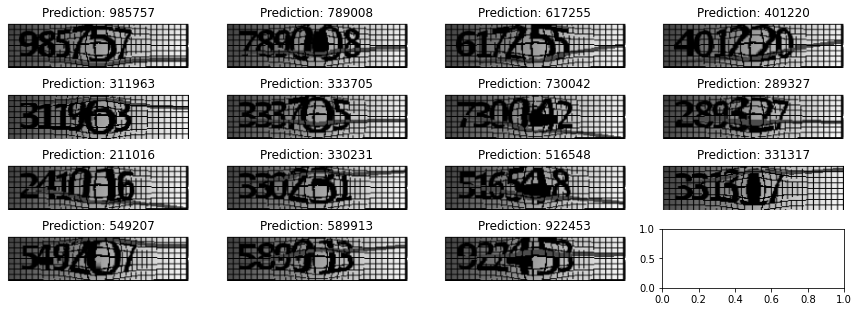

In [20]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)


opt = keras.optimizers.Adam()
    # Compile the model and return
prediction_model.compile(optimizer=opt)


prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Saving trained model

In [69]:
prediction_model

In [74]:
prediction_model.save('new_predict_model2')

INFO:tensorflow:Assets written to: new_predict_model2/assets


# Loading saved trained model

In [75]:
reconstructed_pred_model_2 = keras.models.load_model("new_predict_model2")

In [76]:
reconstructed_pred_model_2

# Predicting new captcha284 with loaded model

In [78]:
#all_image_paths[0:1]
test_img_path =['/home/siva/Downloads/captcha-recognition-pytorch-master/captcha_test/captcha284.png']
test_img_path[0:1]

#print(tf.rank(x_valid))
#print(tf.rank(test_img_path[0:1]))

validation_dataset1 = tf.data.Dataset.from_tensor_slices((test_img_path[0:1], ['']))
validation_dataset1 = (
    validation_dataset1.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

for batch in validation_dataset1.take(1):
    #print(batch['image'])
    
    preds = reconstructed_pred_model_2.predict(batch['image']) # reconstructed_pred_model_2 is saved trained model
    pred_texts = decode_batch_predictions(preds)

print(pred_texts)

['790985']
